In [2]:
from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
import os
import random

/homes/e34960/anaconda3/envs/patchdiff/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
gt_images_folder = "/project/trinity/datasets/apricot/pub/apricot-mask/data_mask_v2"
gt_images_names = os.listdir(gt_images_folder)

print(len(gt_images_names))

873


In [8]:
def compute_vectorized_iou(given_mask, masks):
    given_mask_expanded = np.expand_dims(given_mask, axis=0)
    masks_expanded = np.stack(masks)
    intersection = np.logical_and(masks_expanded > 0, given_mask_expanded > 0)
    union = np.logical_or(masks_expanded > 0, given_mask_expanded > 0)
    intersection_sum = np.sum(intersection, axis=(1, 2))
    union_sum = np.sum(union, axis=(1, 2))
    iou_values = intersection_sum / union_sum
    return iou_values

def getRandomImages(n=1):
    random_numbers = random.sample(range(0, len(gt_images_names)-1), n)

    imgs = []
    img_masks = []
    for i in range(n):
        # idx = random.randint(0,len(gt_images_names)-1)
        img_info = torch.load(os.path.join(gt_images_folder, gt_images_names[random_numbers[i]]))
        img = np.squeeze(img_info['Image'])
        img = np.uint8(img * 255.0)
        img = cv2.resize(img, (512,512), interpolation = cv2.INTER_AREA)
        imgs.append(img)

        img_mask = np.squeeze(img_info['Mask'])
        img_mask = np.uint8(img_mask * 255.0)
        img_mask = cv2.resize(img_mask, (512,512), interpolation = cv2.INTER_AREA)
        img_masks.append(img_mask)

    return imgs, img_masks

In [9]:
sam = sam_model_registry["vit_h"](checkpoint="/project/trinity/pretrained_models/sam_facebook/sam_vit_h_4b8939.pth")
sam.to(device='cuda')
mask_generator = SamAutomaticMaskGenerator(sam)

In [26]:
num_images = 100
img_list, mask_list = getRandomImages(num_images)

patch_indices = []

for i in range(num_images):
    masks = mask_generator.generate(img_list[i])
    all_masks = []
    for z, meta_info in enumerate(masks):
        all_masks.append(meta_info['segmentation'])

    iou_vals = compute_vectorized_iou(mask_list[i], all_masks)
    patch_mask_idx = np.argmax(iou_vals)

    max_frequencies_list = []

    for j in range(len(masks)):
        # fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 20))

        current_mask = masks[j]['segmentation']

        mask_3d = np.repeat(current_mask[:, :, np.newaxis], 3, axis=2)
        masked_img = img_list[i] * mask_3d

        gray_scale = cv2.cvtColor(masked_img, cv2.COLOR_BGR2GRAY)

        fft = np.fft.fft2(gray_scale)
        magnitude_spectrum = np.abs(fft)
        max_frequencies_list.append(magnitude_spectrum[511][511])   # Highest Frequency is N-1, N-1

        # magnitude_spectrum = magnitude_spectrum.flatten()
        # temp_frequencies_list.append(np.partition(magnitude_spectrum, -2)[-2])
        # print(np.max(magnitude_spectrum))

        # axes[0].imshow(img_list[i])
        # axes[0].axis('off')

        # axes[1].imshow(current_mask, cmap='gray')
        # axes[1].axis('off')

        # axes[2].imshow(new_img, cmap='gray')
        # axes[2].axis('off')
        
        # axes[3].imshow(magnitude_spectrum, cmap='gray')
        # axes[3].axis('off')

        # plt.tight_layout()
        # plt.show()
    
    # Highest Frequency for the patch mask
    patch_mask_freq = max_frequencies_list[patch_mask_idx]

    max_frequencies_list.sort(reverse=True)
    patch_indices.append(max_frequencies_list.index(patch_mask_freq))
    


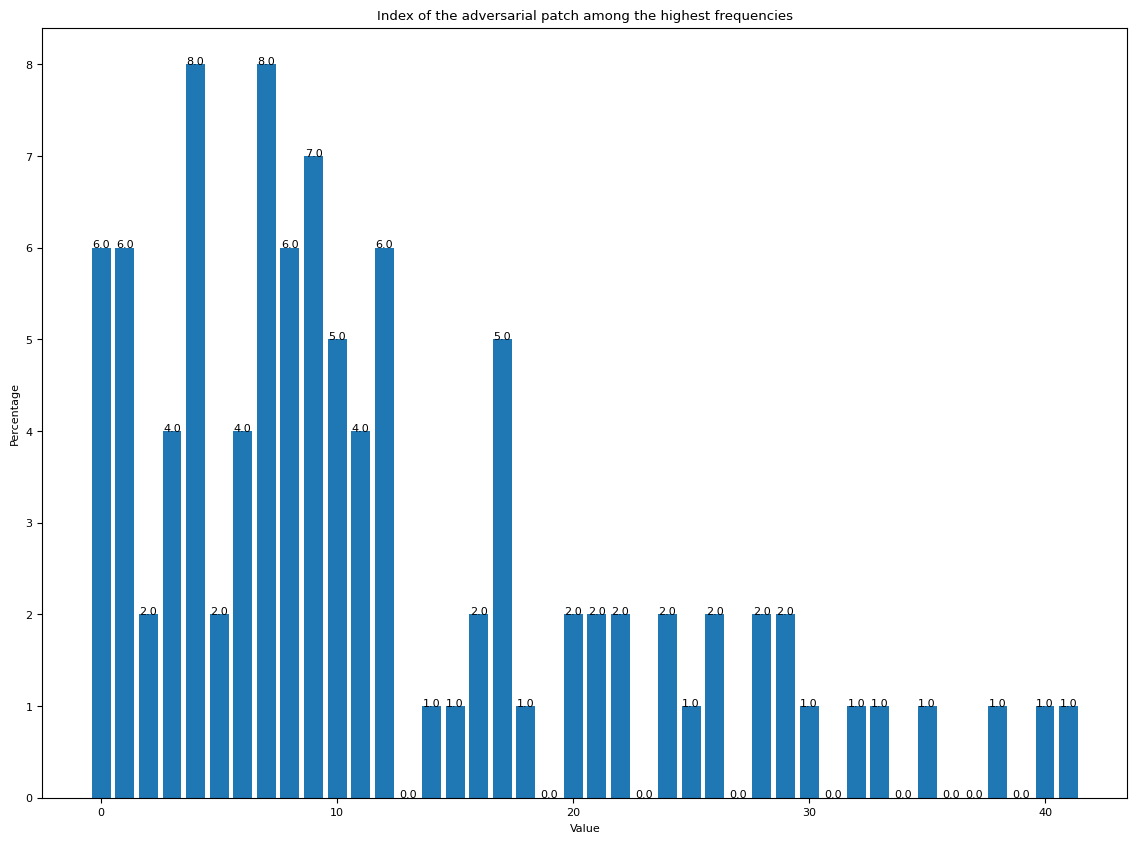

In [41]:
hist, bins = np.histogram(patch_indices, bins=np.arange(np.max(patch_indices) + 1))

plt.figure(figsize=(14,10))
plt.rc('font', size=8)

percentage = hist / len(patch_indices) * 100

# Plot the percentage-wise histogram
plt.bar(bins[:-1], percentage, align='center', width=0.8)
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Index of the adversarial patch among the highest frequencies')

for i in range(len(percentage)):
    plt.text(bins[i], percentage[i], f'{percentage[i]:.1f}', ha='center')

plt.show()